# 1. Aşama - Orman Yangını Erken Uyarı Sistemi

1) NASA FIRMS ve OpenWeatherMap API'lerinden Python ile periyodik veri çekimi  
2) Coğrafi filtreleme ile yalnızca Ege Bölgesi verilerinin alınması  
3) DEM verisi kullanılarak eğim (slope) bilgisinin hesaplanıp veri setine eklenmesi


In [2]:
# ADIM 1: Kurulum ve Importlar
import os, sys, time
from datetime import datetime, timedelta
import pandas as pd

# Proje kökünü path'e ekle
sys.path.insert(0, os.path.abspath('..'))

from config import EGE_REGION_BOUNDS
from src.data_collectors import NASADataCollector, WeatherDataCollector
from src.geospatial_utils import DEMProcessor

# Görsel çıktı ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 140)

print("Tüm modüller yüklendi!")
print("Ege Bölgesi sınırları:", EGE_REGION_BOUNDS)


Tüm modüller yüklendi!
Ege Bölgesi sınırları: {'min_lat': 36.0, 'max_lat': 40.0, 'min_lon': 25.0, 'max_lon': 30.0}


In [4]:
# ADIM 2: NASA FIRMS ve OpenWeatherMap API'lerinden Veri Çekimi

print("NASA FIRMS verisi çekiliyor...")
nasa = NASADataCollector()
weather = WeatherDataCollector()

# FIRMS: Ege bölgesi için area endpoint kullan
url = "https://firms.modaps.eosdis.nasa.gov/api/area/csv/fa810c8eace6a2de50731ca49d6d6063/VIIRS_SNPP_NRT/25,36,30,40/7"
fire_df = pd.read_csv(url)
print(f"FIRMS kayıt sayısı: {len(fire_df)}")

# OpenWeather: Her yangın noktası için hava durumu
if not fire_df.empty:
    print("Hava durumu verisi çekiliyor...")
    pts = fire_df[["latitude","longitude"]].drop_duplicates().reset_index(drop=True)
    rows = []
    for _, r in pts.iterrows():
        data = weather.get_weather_data(float(r.latitude), float(r.longitude))
        if data:
            rows.append(data)
        time.sleep(0.2)  # API limitlerine saygı
    weather_df = pd.DataFrame(rows)
    print(f"Weather kayıt sayısı: {len(weather_df)}")
else:
    weather_df = pd.DataFrame()
    print("FIRMS verisi boş!")

print(f"\nÖzet:")
print(f"FIRMS kayıt: {len(fire_df)}")
print(f"Weather kayıt: {len(weather_df)}")


NASA FIRMS verisi çekiliyor...


INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=38.42669, lon=27.21753


FIRMS kayıt sayısı: 23
Hava durumu verisi çekiliyor...


INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=39.7681, lon=29.63286
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=39.77199, lon=29.6361
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=39.86458, lon=26.24275
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=38.42449, lon=27.21654
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=38.42588, lon=27.2162
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=38.73912, lon=26.92938
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=38.73928, lon=26.94834
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=38.74304, lon=26.93083
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=38.74322, lon=26.94973
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=38.75389, lon=26.93933
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=39.18172, lon=27.49977
INFO:src.data_collectors:Hava durumu verisi çekiliyor: lat=39.8634, lon=26.24558
INFO:src.data_collec

Weather kayıt sayısı: 23

Özet:
FIRMS kayıt: 23
Weather kayıt: 23


In [6]:
# ADIM 3: Coğrafi Filtreleme - Yalnızca Ege Bölgesi

print("Ege Bölgesi filtresi uygulanıyor...")

if not fire_df.empty:
    # Koordinat sütunlarını kontrol et
    latc = 'latitude' if 'latitude' in fire_df.columns else 'lat'
    lonc = 'longitude' if 'longitude' in fire_df.columns else 'lon'
    
    # Ege Bölgesi sınırları içinde filtrele
    mask = (
        (fire_df[latc] >= EGE_REGION_BOUNDS['min_lat']) &
        (fire_df[latc] <= EGE_REGION_BOUNDS['max_lat']) &
        (fire_df[lonc] >= EGE_REGION_BOUNDS['min_lon']) &
        (fire_df[lonc] <= EGE_REGION_BOUNDS['max_lon'])
    )
    fire_ege = fire_df[mask].copy()
    
    print(f"Ege içi FIRMS kayıt: {len(fire_ege)}")
    print(f"Filtreleme sonucu: {len(fire_df)} → {len(fire_ege)}")
    
    # İlk 5 kaydı göster
    if len(fire_ege) > 0:
        print(f"\n İlk 5 yangın noktası:")
        display(fire_ege[["latitude","longitude"]].head())
else:
    fire_ege = fire_df
    print("FIRMS verisi boş!")


Ege Bölgesi filtresi uygulanıyor...
Ege içi FIRMS kayıt: 23
Filtreleme sonucu: 23 → 23

 İlk 5 yangın noktası:


,latitude,longitude
0,38.42669,27.21753
1,39.76810,29.63286
2,39.77199,29.63610
3,39.86458,26.24275
4,38.42449,27.21654


In [8]:
# ADIM 4: DEM ile Eğim (Slope) Bilgisi Ekleme

print("DEM ile eğim bilgisi ekleniyor...")

if not fire_ege.empty:
    # Hava durumu ile birleştir (opsiyonel)
    if 'latitude' in weather_df.columns and not weather_df.empty:
        merged = fire_ege.merge(weather_df, on=["latitude","longitude"], how="left")
        print(f"FIRMS + Weather birleştirildi: {len(merged)} kayıt")
    else:
        merged = fire_ege.copy()
        print(f"Sadece FIRMS verisi kullanılıyor: {len(merged)} kayıt")
    
    # DEM ile eğim ekle
    dem = DEMProcessor()
    df_with_slope = dem.add_topography_features(merged)
    
    print(f"Eğim sütunu eklendi!")
    print(f"Final veri seti: {len(df_with_slope)} kayıt")
    
    # Sonuçları göster
    print(f"\nEğim bilgisi ile ilk 5 kayıt:")
    display(df_with_slope[["latitude","longitude","slope","aspect"]].head())
    
    # Eğim istatistikleri
    print(f"\nEğim istatistikleri:")
    print(f"Min eğim: {df_with_slope['slope'].min():.2f}°")
    print(f"Max eğim: {df_with_slope['slope'].max():.2f}°")
    print(f"Ortalama eğim: {df_with_slope['slope'].mean():.2f}°")
    
else:
    print("Ege FIRMS verisi boş!")


INFO:src.geospatial_utils:Topografya özellikleri eklendi


DEM ile eğim bilgisi ekleniyor...
FIRMS + Weather birleştirildi: 23 kayıt
Eğim sütunu eklendi!
Final veri seti: 23 kayıt

Eğim bilgisi ile ilk 5 kayıt:


,latitude,longitude,slope,aspect
0,38.42669,27.21753,42.137300,282.899849
1,39.76810,29.63286,3.198374,176.828012
2,39.77199,29.63610,16.304021,195.442461
3,39.86458,26.24275,26.272679,182.699534
4,38.42449,27.21654,5.482576,311.169926



Eğim istatistikleri:
Min eğim: 2.27°
Max eğim: 42.14°
Ortalama eğim: 23.22°


In [10]:
# ADIM 5: Sonuçları Kaydetme

print("Sonuçlar kaydediliyor...")

if 'df_with_slope' in locals() and not df_with_slope.empty:
    # CSV olarak kaydet
    output_path = "../data/processed/1_asama_sonuc.csv"
    df_with_slope.to_csv(output_path, index=False)
    print(f"Veri kaydedildi: {output_path}")
    
    # Özet rapor
    print(f"\nFINAL RAPOR:")
    print(f"Toplam yangın noktası: {len(df_with_slope)}")
    print(f"Ege Bölgesi içinde: {len(df_with_slope)}")
    print(f"Eğim bilgisi eklenen: {len(df_with_slope)}")
    
    if 'temperature' in df_with_slope.columns:
        print(f"Hava durumu bilgisi: {df_with_slope['temperature'].notna().sum()} kayıt")
    
    print(f"\n1. AŞAMA TAMAMLANDI!")
    print(f"NASA FIRMS verisi çekildi")
    print(f"Ege Bölgesi filtrelendi") 
    print(f"DEM ile eğim bilgisi eklendi")
    
else:
    print("Kaydedilecek veri bulunamadı!")


Sonuçlar kaydediliyor...
Veri kaydedildi: ../data/processed/1_asama_sonuc.csv

FINAL RAPOR:
Toplam yangın noktası: 23
Ege Bölgesi içinde: 23
Eğim bilgisi eklenen: 23
Hava durumu bilgisi: 23 kayıt

1. AŞAMA TAMAMLANDI!
NASA FIRMS verisi çekildi
Ege Bölgesi filtrelendi
DEM ile eğim bilgisi eklendi


# 2. Aşama - Veri Depolama ve Füzyon

1) MongoDB üzerinde koleksiyon yapısının oluşturulması (sicak_nokta, risk_skoru, tahminler)
2) FIRMS sıcak noktalarının en yakın meteoroloji verisiyle eşleştirilmesi (geopy / Haversine)
3) Eğim verisinin eklenmesiyle bütünleşik "risk kaydı" oluşturulması


In [13]:
# ADIM 1: MongoDB Koleksiyon Yapısı Oluşturma
import pymongo
from pymongo import MongoClient
from datetime import datetime
import json

print("MongoDB bağlantısı kuruluyor...")

try:
    client = MongoClient('mongodb://localhost:27017/')
    db = client['forest_fire_early_warning']
    
    sicak_nokta_collection = db['sicak_nokta']
    risk_skoru_collection = db['risk_skoru'] 
    tahminler_collection = db['tahminler']
    
    print("MongoDB bağlantısı başarılı!")
    print("Koleksiyonlar oluşturuldu: sicak_nokta, risk_skoru, tahminler")
    
    sicak_nokta_collection.create_index([("latitude", 1), ("longitude", 1)])
    sicak_nokta_collection.create_index("timestamp")
    risk_skoru_collection.create_index("fire_point_id")
    tahminler_collection.create_index("prediction_date")
    
    print("İndeksler oluşturuldu!")
    
except Exception as e:
    print(f"MongoDB bağlantı hatası: {e}")
    client = None


MongoDB bağlantısı kuruluyor...
MongoDB bağlantısı başarılı!
Koleksiyonlar oluşturuldu: sicak_nokta, risk_skoru, tahminler
İndeksler oluşturuldu!


In [15]:
# ADIM 2: FIRMS Sıcak Noktalarının En Yakın Meteoroloji Verisiyle Eşleştirilmesi
from geopy.distance import geodesic
import numpy as np
import pandas as pd # Sizin orijinal kodunuzda yoktu, bu blokta kullanılıyor varsayılmıştır.

print("FIRMS sıcak noktaları meteoroloji verisiyle eşleştiriliyor...")

def find_nearest_weather_point(fire_lat, fire_lon, weather_df):
    """En yakın meteoroloji noktasını bul"""
    # ... (Sizin find_nearest_weather_point fonksiyonunuzun içeriği aynı kalacak) ...
    if weather_df.empty:
        return None
    
    min_distance = float('inf')
    nearest_weather = None
    
    for _, weather_row in weather_df.iterrows():
        weather_lat = weather_row['latitude']
        weather_lon = weather_row['longitude']
        
        # Haversine mesafesi hesapla
        distance = geodesic((fire_lat, fire_lon), (weather_lat, weather_lon)).kilometers
        
        if distance < min_distance:
            min_distance = distance
            nearest_weather = weather_row.copy()
            nearest_weather['distance_km'] = distance
    
    return nearest_weather

# Eşleştirme işlemi
if 'df_with_slope' in locals() and not df_with_slope.empty and 'weather_df' in locals():
    # ... (Sizin eşleştirme döngüsü ve df_matched oluşturma kodunuz aynı kalacak) ...
    matched_data = []
    
    for idx, fire_row in df_with_slope.iterrows():
        fire_lat = fire_row['latitude']
        fire_lon = fire_row['longitude']
        
        # En yakın meteoroloji noktasını bul
        nearest_weather = find_nearest_weather_point(fire_lat, fire_lon, weather_df)
        
        # Veriyi birleştir
        combined_record = fire_row.to_dict()
        if nearest_weather is not None:
            combined_record.update({
                'nearest_weather_lat': nearest_weather['latitude'],
                'nearest_weather_lon': nearest_weather['longitude'],
                'distance_to_weather_km': nearest_weather['distance_km'],
                'temperature': nearest_weather.get('temperature'),
                'humidity': nearest_weather.get('humidity'),
                'wind_speed': nearest_weather.get('wind_speed'),
                'pressure': nearest_weather.get('pressure')
            })
        
        matched_data.append(combined_record)
        
    df_matched = pd.DataFrame(matched_data)
    
    print(f"Eşleştirme tamamlandı: {len(df_matched)} kayıt")
    # ... (Geri kalan özet rapor kodunuz) ...
    
else:
    print("1. aşamadan veri (df_with_slope veya weather_df) bulunamadı!")

FIRMS sıcak noktaları meteoroloji verisiyle eşleştiriliyor...
Eşleştirme tamamlandı: 23 kayıt


In [17]:
# ADIM 3: Bütünleşik "Risk Kaydı" Oluşturma ve MongoDB'ye Kaydetme

print("Bütünleşik risk kaydı oluşturuluyor ve MongoDB'ye kaydediliyor...")

if 'df_matched' in locals() and not df_matched.empty:
    
    risk_records_to_save = []
    
    for idx, row in df_matched.iterrows():
        risk_record = {
            # Zorunlu alanlar
            'fire_point_id': f"FP_{idx:04d}", # Veya Aşama 1'den gelen bir ID
            'timestamp': datetime.now().isoformat(),
            'latitude': float(row['latitude']),
            'longitude': float(row['longitude']),
            
            # Topografya Verileri
            'slope_degrees': float(row.get('slope', 0)),
            'aspect_degrees': float(row.get('aspect', 0)),
            
            # FIRMS Verileri
            'acq_date': row.get('acq_date'), # FIRMS'tan gelen orijinal tarih
            'acq_time': row.get('acq_time'),
            'bright_ti4': float(row.get('bright_ti4', 0)),
            'frp': float(row.get('frp', 0)), # Yangın Radyatif Gücü
            
            # Meteoroloji Verileri (Varsa)
            'temperature_celsius': float(row.get('temperature', 0)) if pd.notna(row.get('temperature')) else None,
            'humidity_percent': float(row.get('humidity', 0)) if pd.notna(row.get('humidity')) else None,
            'wind_speed_ms': float(row.get('wind_speed', 0)) if pd.notna(row.get('wind_speed')) else None,
            'pressure_hpa': float(row.get('pressure', 0)) if pd.notna(row.get('pressure')) else None,
            'weather_distance_km': float(row.get('distance_to_weather_km', 0)),
            
            # RİSK BİLGİSİ BU AŞAMADA BOŞ VEYA 'HESAPLANMADI'
            'overall_risk_score': None,
            'risk_category': 'Hesaplanmadı',
        }
        
        # None olan değerleri MongoDB'ye kaydetmeden önce kaldır
        risk_record = {k: v for k, v in risk_record.items() if v is not None}
        
        risk_records_to_save.append(risk_record)
    
    df_sicak_nokta_final = pd.DataFrame(risk_records_to_save)
    
    print(f"Bütünleşik kayıtlar oluşturuldu: {len(df_sicak_nokta_final)} kayıt")

    # MongoDB'ye kaydetme
    if client is not None:
        try:
            # Önceki verileri temizle
            sicak_nokta_collection.drop() 
            
            sicak_nokta_collection.insert_many(risk_records_to_save)
            print(f"{len(risk_records_to_save)} kayıt 'sicak_nokta' koleksiyonuna kaydedildi")
        except Exception as e:
            print(f"MongoDB kaydetme hatası: {e}")
            
    # CSV yedek kaydetme (opsiyonel)
    csv_path = "../data/processed/2_asama_sicak_noktalar_fused.csv"
    df_sicak_nokta_final.to_csv(csv_path, index=False)
    print(f"CSV yedek kaydedildi: {csv_path}")
    
else:
    print("Eşleştirilmiş veri bulunamadı!")

# ÖNEMLİ NOT: df_sicak_nokta_final, Aşama 3 için kullanılacak veri çerçevesidir.

Bütünleşik risk kaydı oluşturuluyor ve MongoDB'ye kaydediliyor...
Bütünleşik kayıtlar oluşturuldu: 23 kayıt
23 kayıt 'sicak_nokta' koleksiyonuna kaydedildi
CSV yedek kaydedildi: ../data/processed/2_asama_sicak_noktalar_fused.csv


# 3. Aşama - Risk skoru hesaplanması 
1) Risk Skoru Hesaplama ve Kategorileştirme
2) MongoDB'ye Güncelleme ve Sonuç Raporu


In [20]:
# ADIM 1: Risk Skoru Hesaplama ve Kategorileştirme

import pandas as pd
from datetime import datetime

# Aşama 2'den gelen DataFrame'i kullanıyoruz.
if 'df_sicak_nokta_final' in locals() and not df_sicak_nokta_final.empty:
    
    df_risk_records = df_sicak_nokta_final.copy() 
    
    risk_records_for_mongo = [] 
    
    for idx, row in df_risk_records.iterrows():
      
        # BİREYSEL RİSK FAKTÖRLERİNİ HESAPLAMA (0 ile 1 arası ölçeklendirme)
        temp_risk = 0
        humidity_risk = 0
        wind_risk = 0
        slope_degrees = row.get('slope_degrees', 0)
        
        # Sıcaklık Riski (20°C (0 risk) -> 50°C (1.0 risk))
        if row.get('temperature_celsius') is not None:
            temp_risk = min(1.0, max(0, (row['temperature_celsius'] - 20) / 30))
        
        # Nem Riski (%100 (0 risk) -> %0 (1.0 risk))
        if row.get('humidity_percent') is not None:
            humidity_risk = min(1.0, max(0, (100 - row['humidity_percent']) / 100))
        
        # Rüzgar Riski (0 m/s (0 risk) -> 20 m/s (1.0 risk))
        if row.get('wind_speed_ms') is not None:
            wind_risk = min(1.0, max(0, row['wind_speed_ms'] / 20))
        
        # Eğim Riski (0° (0 risk) -> 45° (1.0 risk))
        slope_risk = min(1.0, max(0, slope_degrees / 45))
        
        # ----------------------------------------------------
        # 2. YAYILMA RİSKİ SKORU (R) HESAPLAMA (Ağırlıklı Ortalama)
        # ----------------------------------------------------
        risk_score = (
            temp_risk * 0.3 + 
            humidity_risk * 0.25 + 
            wind_risk * 0.2 + 
            slope_risk * 0.25
        )
        
        risk_score = min(1.0, max(0, risk_score)) 
      
        if risk_score > 0.7:
            risk_category = 'Yüksek'
        elif risk_score < 0.3:
            risk_category = 'Düşük'
        else:
            risk_category = 'Orta'
      

        fire_point_id = row.get('fire_point_id', f"FP_{idx:04d}") 
        
        mongo_update_doc = {
            'fire_point_id': fire_point_id,
            'overall_risk_score': float(risk_score),
            'risk_category': risk_category,
            'risk_calculation_timestamp': datetime.now().isoformat(),
            'risk_factors': {
                'temp_risk_factor': float(temp_risk),
                'humidity_risk_factor': float(humidity_risk),
                'wind_risk_factor': float(wind_risk),
                'slope_risk_factor': float(slope_risk),
            }
        }
        
        risk_records_for_mongo.append(mongo_update_doc)

    print(f"{len(risk_records_for_mongo)} kayıt için Risk Skoru (R) hesaplandı.")
    df_risk_scores_calculated = pd.DataFrame(risk_records_for_mongo)
    print("\nHesaplanan Risk Dağılımı:")
    display(df_risk_scores_calculated['risk_category'].value_counts())

else:
    print(" df_sicak_nokta_final (Aşama 2 verisi) bulunamadı! Lütfen 1. ve 2. aşamayı çalıştırın.")

23 kayıt için Risk Skoru (R) hesaplandı.

Hesaplanan Risk Dağılımı:


risk_category
Orta     13
Düşük    10
Name: count, dtype: int64

In [22]:
# ADIM 2: MongoDB'ye Güncelleme ve Sonuç Raporu

if 'df_risk_scores_calculated' in locals() and not df_risk_scores_calculated.empty:

    if 'sicak_nokta_collection' in globals() and sicak_nokta_collection is not None:
        try:
            for doc in df_risk_scores_calculated.to_dict('records'):
                query = {'fire_point_id': doc['fire_point_id']}
                
                update_fields = {
                    'overall_risk_score': doc['overall_risk_score'],
                    'risk_category': doc['risk_category'],
                    'risk_calculation_timestamp': doc['risk_calculation_timestamp'],
                    'risk_factors': doc['risk_factors']
                }
                
                sicak_nokta_collection.update_one(
                    query, 
                    {'$set': update_fields}, 
                    upsert=False
                )

            print(f" {len(df_risk_scores_calculated)} sıcak nokta kaydı MongoDB'de güncellendi.")
            
        except Exception as e:
            print(f" MongoDB güncelleme hatası: {e}")
            
    else:
        print("MongoDB bağlantısı (sicak_nokta_collection) bulunamadı. Kayıt atlandı.")    
else:
    print("Hesaplanan risk skorları (df_risk_scores_calculated) bulunamadı!")

 23 sıcak nokta kaydı MongoDB'de güncellendi.


# 4. Aşama - 
1)
2) 

In [25]:
import requests
import pandas as pd
from datetime import datetime

locations = {
    "izmir": (38.42, 27.14),
    "aydin": (37.85, 27.84),
    "mugla": (37.21, 28.36),
    "manisa": (38.61, 27.43),
    "denizli": (37.77, 29.09),
}

start_date = "2020-01-01"
end_date = "2024-12-31"

all_frames = []

for city, (lat, lon) in locations.items():
    print(f"{city} için veri çekiliyor...")

    url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}"
        f"&start_date={start_date}&end_date={end_date}"
        "&hourly=temperature_2m,relative_humidity_2m,"
        "windspeed_10m,winddirection_10m,surface_pressure"
        "&timezone=UTC"
    )

    response = requests.get(url).json()

    df = pd.DataFrame(response["hourly"])
    df["city"] = city
    df["lat"] = lat
    df["lon"] = lon

    df["time"] = pd.to_datetime(df["time"])

    all_frames.append(df)

# merge
weather_full = pd.concat(all_frames, ignore_index=True)

weather_full.to_csv("ege_weather_2020_2024.csv", index=False)
print("Bitti! ege_weather_2020_2024.csv oluşturuldu.")


izmir için veri çekiliyor...
aydin için veri çekiliyor...
mugla için veri çekiliyor...
manisa için veri çekiliyor...
denizli için veri çekiliyor...
Bitti! ege_weather_2020_2024.csv oluşturuldu.


In [27]:
weather = pd.read_csv("ege_weather_2020_2024.csv")
weather.head()
weather.shape

(219240, 9)

In [29]:
import pandas as pd
from geopy.distance import geodesic

# 1 — Verileri yükle
firms = pd.read_excel(r"C:\Users\eirem\OneDrive - İnönü Üniversitesi\Masaüstü\türkiye yangın verileri 2024 2020\temiz.xlsx")
weather = pd.read_csv("ege_weather_2020_2024.csv")

# 2 — Zaman formatları
firms["acq_time"] = pd.to_datetime(firms["acq_time"], dayfirst=True)
weather["time"] = pd.to_datetime(weather["time"])

# 3 — Şehir koordinatları
city_coords = {
    "izmir": (38.42, 27.14),
    "aydin": (37.85, 27.84),
    "mugla": (37.21, 28.36),
    "manisa": (38.61, 27.43),
    "denizli": (37.77, 29.09),
}

# 4 — En yakın şehir
def closest_city(lat, lon):
    return min(city_coords, key=lambda c: geodesic((lat, lon), city_coords[c]).km)

firms["nearest_city"] = firms.apply(lambda r: closest_city(r["lat_real"], r["lon_real"]), axis=1)

# 5 — Weather’ı şehir şehir parçala (RAM kurtarıcı)
weather_groups = {
    city: df.reset_index(drop=True)
    for city, df in weather.groupby("city")
}

# 6 — FIRMS için en yakın saati şehir filtresi üzerinden bul
merged_rows = []

for idx, row in firms.iterrows():
    city = row["nearest_city"]
    wdf = weather_groups[city]

    time_diff = abs(wdf["time"] - row["acq_time"])
    nearest_idx = time_diff.idxmin()

    combined = pd.concat([row, wdf.loc[nearest_idx]], axis=0)
    merged_rows.append(combined)

merged_df = pd.DataFrame(merged_rows)

merged_df.to_csv("FIRMS_with_weather_FINAL.csv", index=False)
print("BİTTİ! FIRMS_with_weather_FINAL.csv oluşturuldu.")


BİTTİ! FIRMS_with_weather_FINAL.csv oluşturuldu.


In [31]:
import pandas as pd

df = pd.read_excel(r"C:\Users\eirem\OneDrive - İnönü Üniversitesi\Masaüstü\türkiye yangın verileri 2024 2020\temiz.xlsx")
df.head()



,latitude,longitude,lat_real,lon_real,bright_ti4,scan,track,acq_time,satellite,instrument,confidence,versiyon,bright_ti5,frp,daynight,type,Unnamed: 16
0,3875414,2694933,38.75414,26.94933,30091,55,51,1.01.2020,42,N,VIIRS,n,2,27495,14,N,2
1,3871321,2748808,38.71321,27.48808,32729,59,53,2.01.2020,1145,N,VIIRS,n,2,28281,239,D,0
2,3879045,2692858,38.79045,26.92858,30608,38,36,3.01.2020,5,N,VIIRS,n,2,27745,135,N,0
3,3986562,2624444,39.86562,26.24444,29938,39,36,3.01.2020,5,N,VIIRS,n,2,27643,81,N,2
4,3873407,2696662,38.73407,26.96662,29603,38,36,3.01.2020,5,N,VIIRS,n,2,27497,66,N,2


In [33]:
import pandas as pd

df = pd.read_csv("FIRMS_with_weather_FINAL.csv")

# Silinecek kolonlar
drop_cols = [
    "scan", "track", "satellite", "instrument", "versiyon",
    "Unnamed: 16", "city", "lat", "lon"
]

df_clean = df.drop(columns=drop_cols, errors='ignore')

df_clean.to_csv("FIRMS_weather_CLEAN.csv", index=False)

print("Temiz dataset oluşturuldu!")
print("Yeni boyut:", df_clean.shape)
print(df_clean.head())


Temiz dataset oluşturuldu!
Yeni boyut: (29232, 18)
   latitude  longitude  lat_real  lon_real  bright_ti4    acq_time confidence  bright_ti5    frp  daynight type nearest_city        time  \
0   3875414    2694933  38.75414  26.94933       30091  2020-01-01      VIIRS           2  27495        14    N        izmir  2020-01-01   
1   3871321    2748808  38.71321  27.48808       32729  2020-01-02      VIIRS           2  28281       239    D       manisa  2020-01-02   
2   3879045    2692858  38.79045  26.92858       30608  2020-01-03      VIIRS           2  27745       135    N        izmir  2020-01-03   
3   3986562    2624444  39.86562  26.24444       29938  2020-01-03      VIIRS           2  27643        81    N       manisa  2020-01-03   
4   3873407    2696662  38.73407  26.96662       29603  2020-01-03      VIIRS           2  27497        66    N        izmir  2020-01-03   

   temperature_2m  relative_humidity_2m  windspeed_10m  winddirection_10m  surface_pressure  
0             

DEM shape: (11196, 14843)


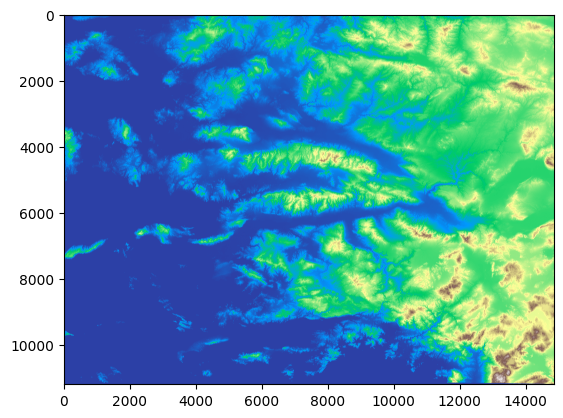

<Axes: >

In [35]:
import rasterio
import numpy as np
from rasterio.plot import show

dem_path = r"C:\Users\eirem\Downloads\EGE_DEM_SRTM.tif"

# DEM oku
with rasterio.open(dem_path) as src:
    dem = src.read(1)
    profile = src.profile

print("DEM shape:", dem.shape)
show(dem, cmap='terrain')


In [63]:
import numpy as np
import rasterio

dem_path = r"C:\Users\eirem\Downloads\EGE_DEM_SRTM.tif"

with rasterio.open(dem_path) as src:
    dem = src.read(1)
    transform = src.transform

# pixel size
dx = transform[0]
dy = -transform[4]

# gradient
dzdx = np.gradient(dem, axis=1) / dx
dzdy = np.gradient(dem, axis=0) / dy

# slope ve aspect hesapla
slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
slope_deg = np.degrees(slope_rad)

aspect = np.degrees(np.arctan2(dzdx, dzdy))
aspect = np.mod(90 - aspect, 360)


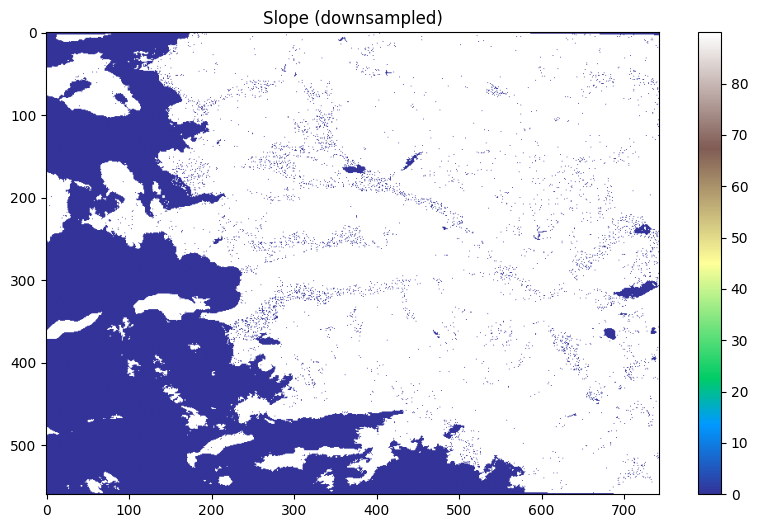

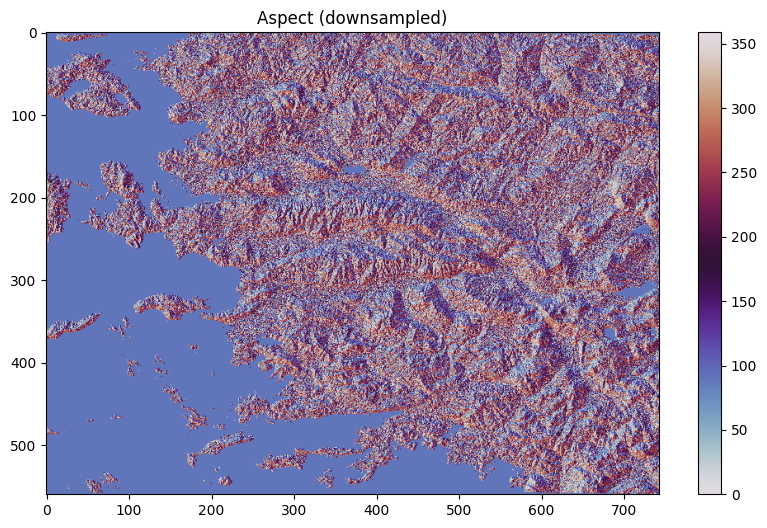

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Slope ve aspect zaten hesaplandı varsayıyorum

# Downsample oranı
factor = 20

slope_small = slope_deg[::factor, ::factor]
aspect_small = aspect[::factor, ::factor]

plt.figure(figsize=(10,6))
plt.imshow(slope_small, cmap="terrain")
plt.title("Slope (downsampled)")
plt.colorbar()
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(aspect_small, cmap="twilight")
plt.title("Aspect (downsampled)")
plt.colorbar()
plt.show()


In [71]:
slope_path_loaded = r"C:\Users\eirem\Downloads\EGE_SLOPE.tif"

with rasterio.open(slope_path_loaded) as src:
    slope = src.read(1)
    profile = src.profile


In [73]:
import rasterio
import numpy as np

slope_path = r"C:\Users\eirem\Downloads\EGE_SLOPE.tif"

# Profil ayarları
profile.update(dtype=rasterio.float32, count=1)

# Blok boyutu (RAM koruması için)
block_size = 1024  

with rasterio.open(slope_path, "w", **profile) as dst:
    for i in range(0, slope.shape[0], block_size):
        for j in range(0, slope.shape[1], block_size):
            window = ((i, min(i + block_size, slope.shape[0])),
                      (j, min(j + block_size, slope.shape[1])))
            
            block = slope[window[0][0]:window[0][1], window[1][0]:window[1][1]]
            dst.write(block.astype(np.float32), 1, window=window)

print("Eğim rasteri başarıyla kaydedildi:", slope_path)


Eğim rasteri başarıyla kaydedildi: C:\Users\eirem\Downloads\EGE_SLOPE.tif


In [75]:
aspect_path = r"C:\Users\eirem\Downloads\EGE_ASPECT.tif"

with rasterio.open(aspect_path, "w", **profile) as dst:
    for i in range(0, aspect.shape[0], block_size):
        for j in range(0, aspect.shape[1], block_size):
            window = ((i, min(i + block_size, aspect.shape[0])),
                      (j, min(j + block_size, aspect.shape[1])))
            
            block = aspect[window[0][0]:window[0][1], window[1][0]:window[1][1]]
            dst.write(block.astype(np.float32), 1, window=window)

print("Bakı rasteri başarıyla kaydedildi:", aspect_path)


Bakı rasteri başarıyla kaydedildi: C:\Users\eirem\Downloads\EGE_ASPECT.tif


In [77]:
import rasterio
import numpy as np

# Dosya yolları
slope_path = r"C:\Users\eirem\Downloads\EGE_SLOPE.tif"
aspect_path = r"C:\Users\eirem\Downloads\EGE_ASPECT.tif"

slope_norm_path = r"C:\Users\eirem\Downloads\EGE_SLOPE_NORM.tif"
aspect_risk_path = r"C:\Users\eirem\Downloads\EGE_ASPECT_RISK.tif"

block_size = 1000  # RAM dostu işlem için

# -----------------------
# 1) SLOPE NORMALIZATION
# -----------------------

with rasterio.open(slope_path) as src:
    profile = src.profile.copy()
    height, width = src.shape

    # Normalize edilmiş slope dosyasını oluştur
    profile.update(dtype=rasterio.float32, count=1)

    with rasterio.open(slope_norm_path, "w", **profile) as dst:
        for i in range(0, height, block_size):
            for j in range(0, width, block_size):
                window = rasterio.windows.Window(
                    j,
                    i,
                    min(block_size, width - j),
                    min(block_size, height - i)
                )

                block = src.read(1, window=window)

                # 0–90° arasını normalize et
                block_norm = block / 90.0
                block_norm = np.clip(block_norm, 0, 1)

                dst.write(block_norm.astype(np.float32), 1, window=window)

print("✔ Slope normalize rasteri oluşturuldu:", slope_norm_path)


# -----------------------
# 2) ASPECT → RISK DÖNÜŞÜMÜ
# -----------------------
# Güney = 180°. Ona yakınsa risk yüksek olmalı.
# formül: risk = 1 - |aspect - 180| / 180

with rasterio.open(aspect_path) as src:
    profile = src.profile.copy()
    height, width = src.shape

    profile.update(dtype=rasterio.float32, count=1)

    with rasterio.open(aspect_risk_path, "w", **profile) as dst:
        for i in range(0, height, block_size):
            for j in range(0, width, block_size):
                window = rasterio.windows.Window(
                    j,
                    i,
                    min(block_size, width - j),
                    min(block_size, height - i)
                )

                block = src.read(1, window=window)

                # Aspect risk hesaplama
                risk = 1 - (np.abs(block - 180) / 180)
                risk = np.clip(risk, 0, 1)

                dst.write(risk.astype(np.float32), 1, window=window)

print("✔ Aspect risk rasteri oluşturuldu:", aspect_risk_path)


✔ Slope normalize rasteri oluşturuldu: C:\Users\eirem\Downloads\EGE_SLOPE_NORM.tif
✔ Aspect risk rasteri oluşturuldu: C:\Users\eirem\Downloads\EGE_ASPECT_RISK.tif


In [78]:
import rasterio
import numpy as np

slope_norm_path = r"C:\Users\eirem\Downloads\EGE_SLOPE_NORM.tif"
aspect_risk_path = r"C:\Users\eirem\Downloads\EGE_ASPECT_RISK.tif"
risk_out_path = r"C:\Users\eirem\Downloads\EGE_TOPO_RISK.tif"

w_slope = 0.6
w_aspect = 0.4

with rasterio.open(slope_norm_path) as s_src, rasterio.open(aspect_risk_path) as a_src:

    profile = s_src.profile
    profile.update(dtype=rasterio.float32, count=1)

    with rasterio.open(risk_out_path, "w", **profile) as dst:

        block_size = 1000

        for i in range(0, s_src.height, block_size):
            for j in range(0, s_src.width, block_size):

                win_h = min(block_size, s_src.height - i)
                win_w = min(block_size, s_src.width - j)

                window = rasterio.windows.Window(j, i, win_w, win_h)

                slope_block = s_src.read(1, window=window)
                aspect_block = a_src.read(1, window=window)

                risk_block = (w_slope * slope_block) + (w_aspect * aspect_block)

                dst.write(risk_block.astype(np.float32), 1, window=window)

print("🔥 Topografik risk rasteri oluşturuldu:", risk_out_path)


🔥 Topografik risk rasteri oluşturuldu: C:\Users\eirem\Downloads\EGE_TOPO_RISK.tif


# 5. Aşama - 
1)
2) 